In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import xgboost as xgb
import shap
import datetime
import warnings
warnings.filterwarnings("ignore")

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

Added: /Users/lsanchez/omath_mota_rulo


In [2]:
from data_scientia.features import train_data
from data_scientia.models.eval import eval_utils

In [3]:
data = train_data.get()
data = data[data['fecha'] < '2020-11-12']
data.shape

(10536, 96)

In [4]:
target = 'is_next_peak_in_15_days'

In [5]:
experiment_rounds_data = data[data['fecha'] > data['fecha'].quantile(.5)]

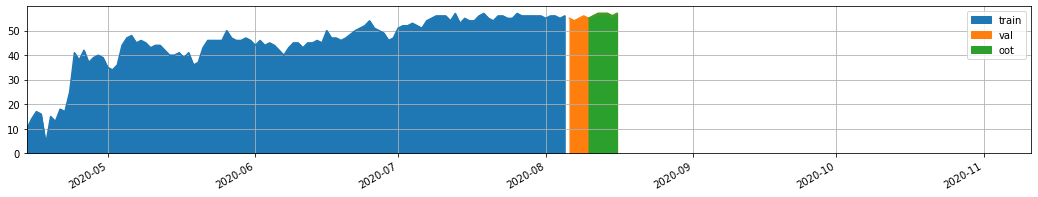

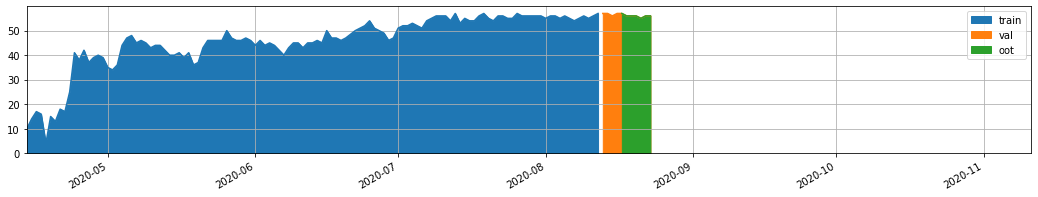

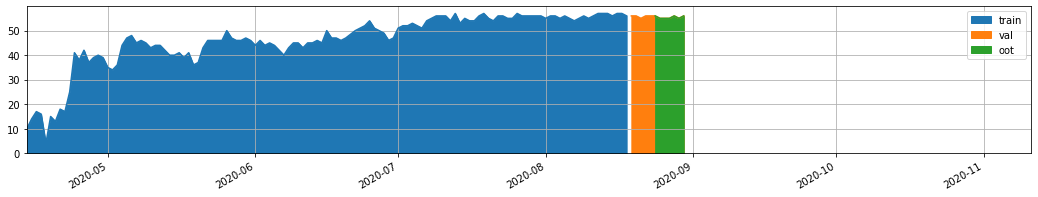

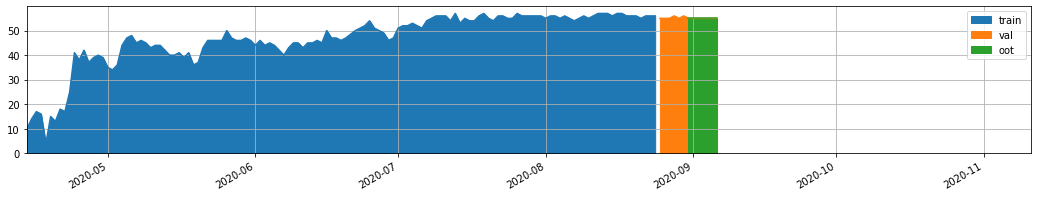

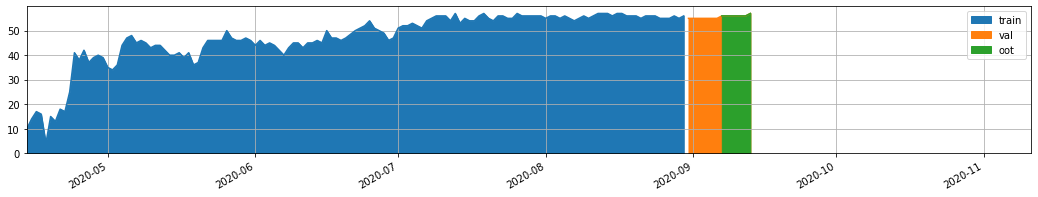

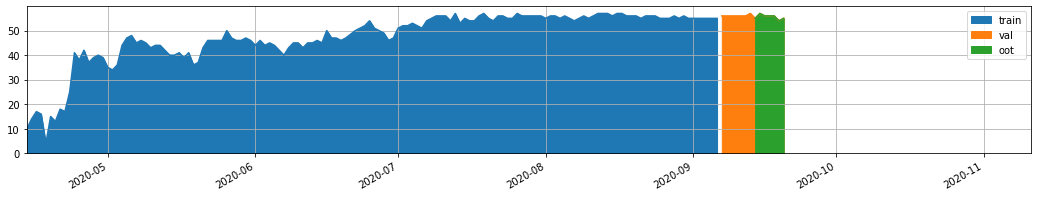

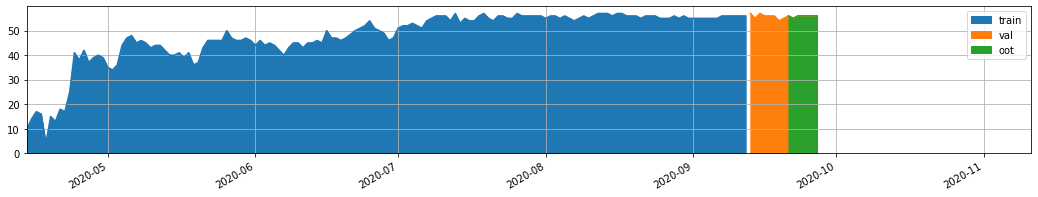

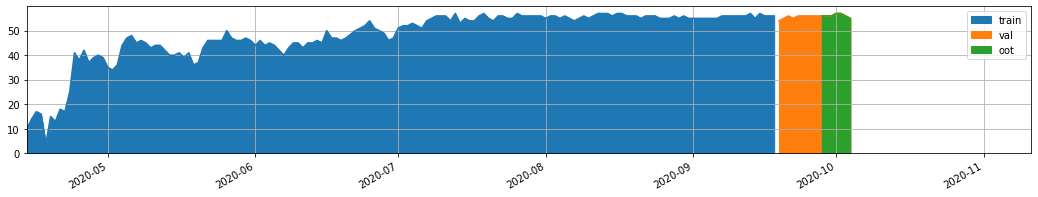

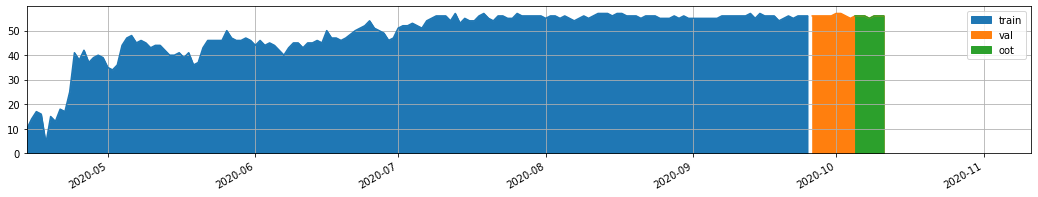

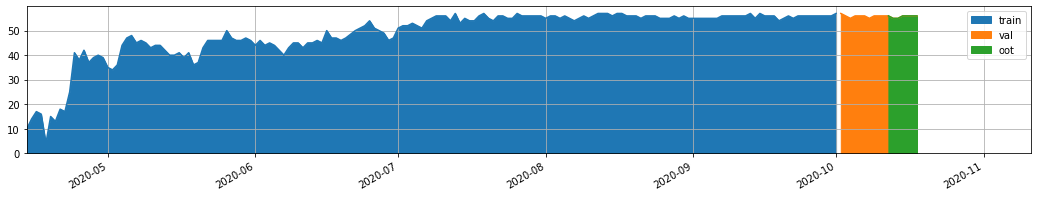

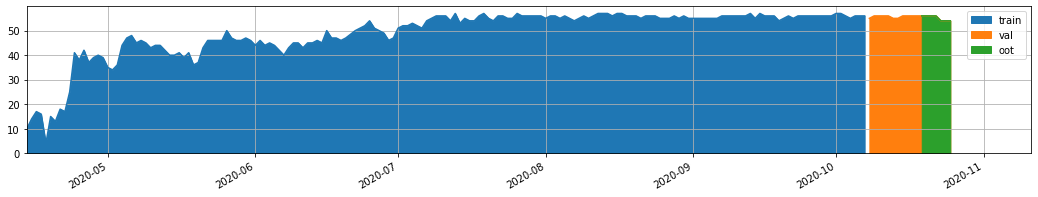

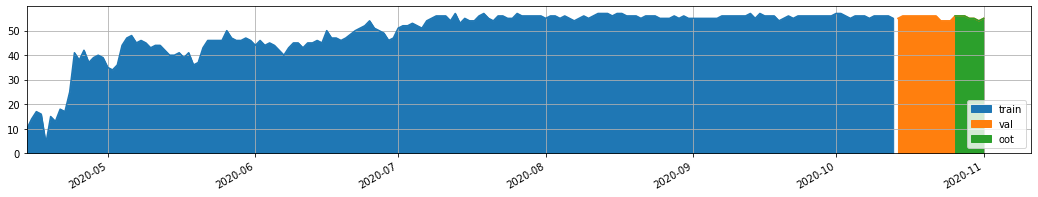

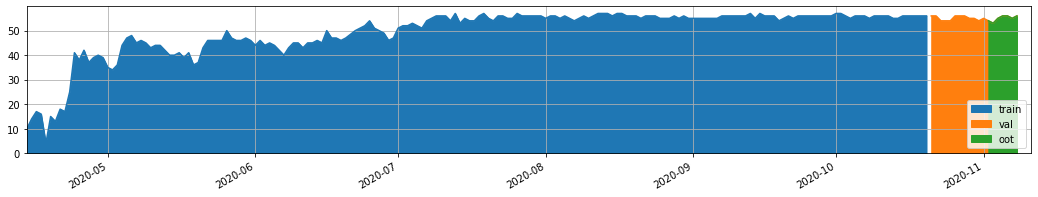

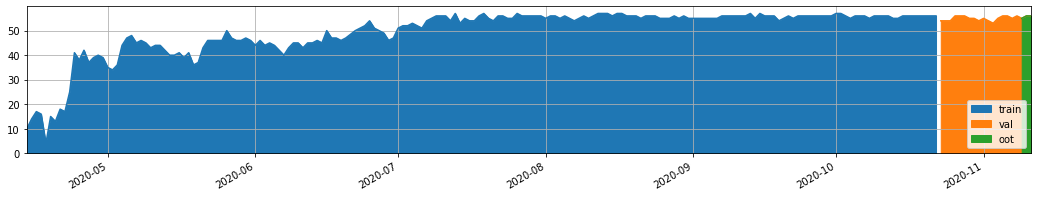

In [6]:
def plot_folds(X_train, X_val, X_oot):
    fig, ax = plt.subplots(1, 1, figsize=(18, 3))

    data_plot = train['fecha'].value_counts()
    data_plot.name = 'train'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True,
        ax=ax)

    data_plot = val['fecha'].value_counts()
    data_plot.name = 'val'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True, 
        ax=ax)

    data_plot = oot['fecha'].value_counts()
    data_plot.name = 'oot'
    data_plot.plot(
        kind='area',
        grid=True,
        legend=True, 
        ax=ax)
    ax.set_xlim(
        date2num(data['fecha'].min()),
        date2num(data['fecha'].max()))
    
    return fig, ax

reports, feature_importance, dates = [], [], []
for date, oot in experiment_rounds_data.set_index('fecha').groupby(pd.Grouper(freq='W')):
    dates.append(date)
    oot.reset_index(inplace=True)
    train = data[data['fecha'] <= date]

    oos_size = .1
    val_boundary = train['fecha'].quantile(1 - oos_size)

    val = train[train['fecha'] >= val_boundary]
    train = train[train['fecha'] < val_boundary]
    
    plot_folds(train, val, oot)

[22:16:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.977169  0.230603  0.373147   3712.0   876.0  0.815109
1             0.321293  0.985423  0.484588   1372.0  4208.0  0.815109
avg / total   0.800170  0.434304  0.403221   5084.0  5084.0  0.815109, 'val':              precision    recall  f1-score  support   pred       AUC
0             0.955263  0.624785  0.755463    581.0  380.0  0.690088
1             0.072340  0.500000  0.126394     34.0  235.0  0.690088
avg / total   0.906451  0.617886  0.720685    615.0  615.0  0.690088, 'oot':              precision    

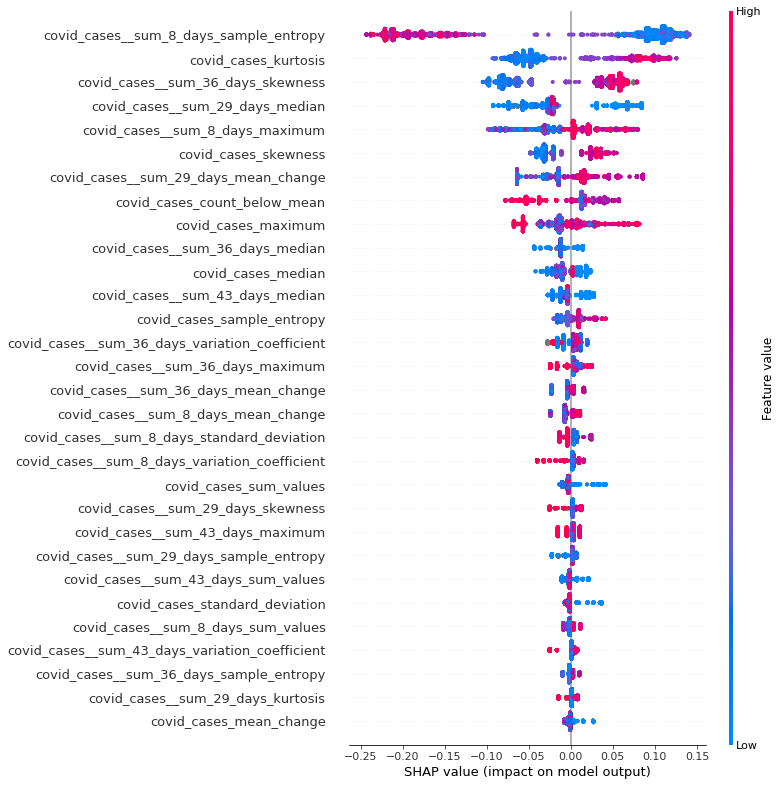

[22:16:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.982114  0.295861  0.454734   4083.0  1230.0  0.827645
1             0.322254  0.984161  0.485527   1389.0  4242.0  0.827645
avg / total   0.814616  0.470577  0.462550   5472.0  5472.0  0.827645, 'val':              precision    recall  f1-score  support   pred       AUC
0             0.967462  0.775652  0.861004    575.0  461.0  0.785474
1             0.183544  0.659091  0.287129     44.0  158.0  0.785474
avg / total   0.911739  0.767367  0.820211    619.0  619.0  0.785474, 'oot':              precision    

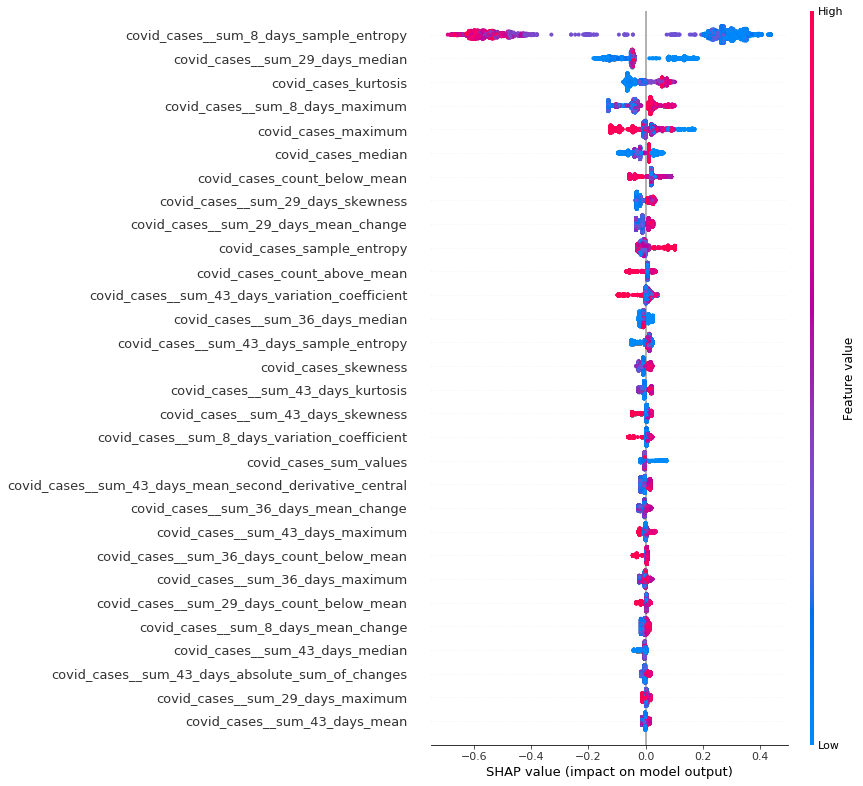

[22:16:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.996377  0.187628  0.315789   4397.0   828.0  0.849906
1             0.283307  0.997880  0.441319   1415.0  4984.0  0.849906
avg / total   0.822771  0.384893  0.346351   5812.0  5812.0  0.849906, 'val':              precision    recall  f1-score  support   pred       AUC
0             0.995157  0.650316  0.786603    632.0  413.0  0.895344
1             0.129921  0.942857  0.228374     35.0  254.0  0.895344
avg / total   0.949755  0.665667  0.757310    667.0  667.0  0.895344, 'oot':              precision    

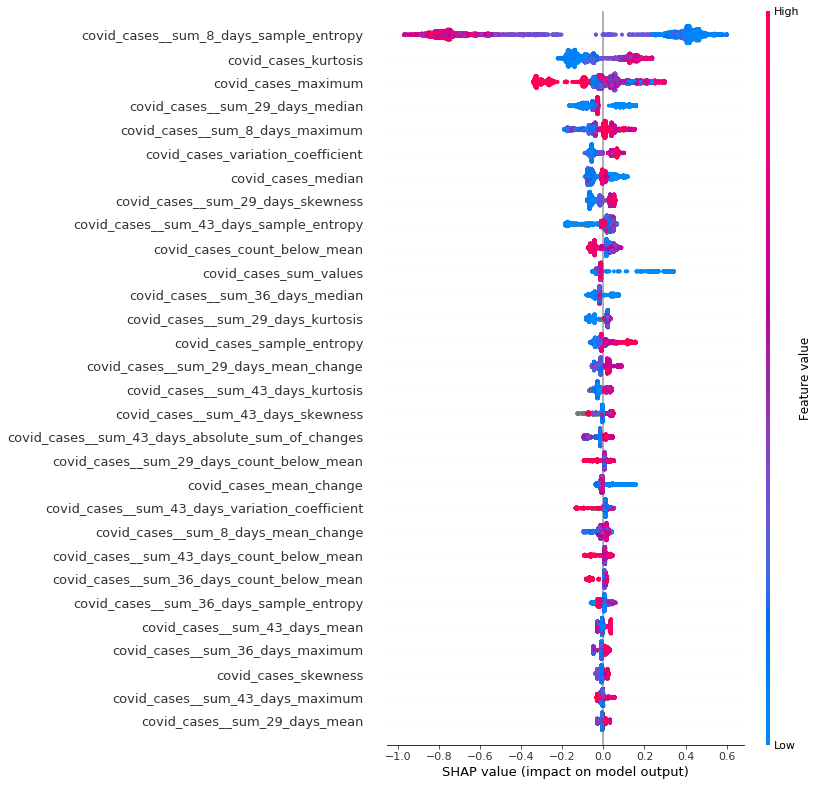

[22:16:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             1.000000  0.145829  0.254539   4711.0   687.0  0.861704
1             0.263004  1.000000  0.416473   1436.0  5460.0  0.861704
avg / total   0.827830  0.345372  0.292368   6147.0  6147.0  0.861704, 'val':              precision    recall  f1-score  support   pred       AUC
0             0.995204  0.598846  0.747748    693.0  417.0  0.935305
1             0.073333  0.916667  0.135802     24.0  300.0  0.935305
avg / total   0.964346  0.609484  0.727264    717.0  717.0  0.935305, 'oot':              precision    

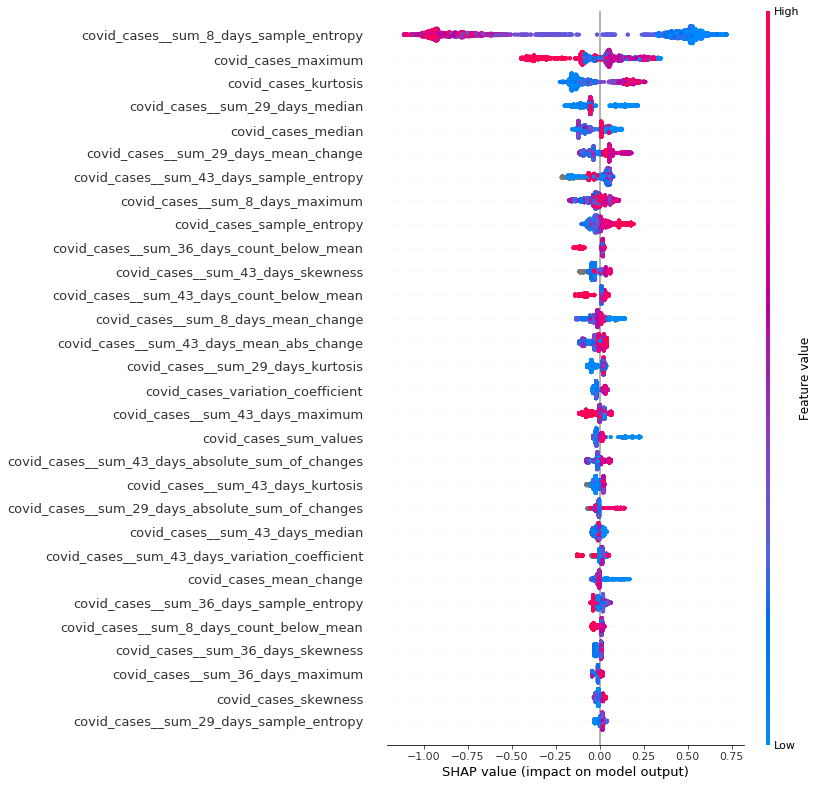

[22:16:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { col_subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'train':              precision    recall  f1-score  support    pred       AUC
0             0.997155  0.139392  0.244592   5029.0   703.0  0.838019
1             0.250693  0.998621  0.400775   1450.0  5776.0  0.838019
avg / total   0.830097  0.331687  0.279546   6479.0  6479.0  0.838019, 'val':              precision    recall  f1-score  support   pred       AUC
0             0.979592  0.649526  0.781123    739.0  490.0  0.793935
1             0.100694  0.743590  0.177370     39.0  288.0  0.793935
avg / total   0.935534  0.654242  0.750858    778.0  778.0  0.793935, 'oot':              precision    

In [ ]:
reports, feature_importance, dates = [], [], []
for date, oot in experiment_rounds_data.set_index('fecha').groupby(pd.Grouper(freq='W')):
    dates.append(date)
    oot.reset_index(inplace=True)
    train = data[data['fecha'] <= date]

    oos_size = .1
    val_boundary = train['fecha'].quantile(1 - oos_size)

    val = train[train['fecha'] >= val_boundary]
    train = train[train['fecha'] < val_boundary]
    
    # Split data
    X_train = train.set_index(['fecha', 'nombre_hospital']).copy()
    X_train.drop(list(set(X_train.columns).intersection(train_data._TARGETS)), axis=1, inplace=True)
    y_train = train.set_index(['fecha', 'nombre_hospital'])[target]

    X_val = val.set_index(['fecha', 'nombre_hospital']).copy()
    X_val.drop(list(set(X_val.columns).intersection(train_data._TARGETS)), axis=1, inplace=True)
    y_val = val.set_index(['fecha', 'nombre_hospital'])[target]

    X_oot = oot.set_index(['fecha', 'nombre_hospital']).copy()
    X_oot.drop(list(set(X_oot.columns).intersection(train_data._TARGETS)), axis=1, inplace=True)
    y_oot = oot.set_index(['fecha', 'nombre_hospital'])[target]
       
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    model = xgb.XGBClassifier(
        subsample=.7,
        col_subsample=.5,
        max_depth=4,
        learning_rate=.05,
        min_child_weight=100,
        scale_pos_weight=scale_pos_weight
    )

    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric=['logloss', 'auc'],
        early_stopping_rounds=10,
        verbose=False)

    y_train_score = model.predict_proba(X_train)
    y_val_score = model.predict_proba(X_val)
    y_oot_score = model.predict_proba(X_oot)

    # Evaluate
    score_th = pd.Series(y_oot_score[:, 1]).quantile(.5)
    report_train = eval_utils.classification_report(
        y_true=y_train, 
        y_score=y_train_score, 
        y_pred=(y_train_score[:, 1] > score_th).astype(int))

    report_val = eval_utils.classification_report(
        y_true=y_val, 
        y_score=y_val_score, 
        y_pred=(y_val_score[:, 1] > score_th).astype(int))

    report_oot = eval_utils.classification_report(
        y_true=y_oot, 
        y_score=y_oot_score, 
        y_pred=(y_oot_score[:, 1] > score_th).astype(int))
    
    local_reports = {
        'train': report_train,
        'val': report_val,
        'oot': report_oot,
        'date': date
    }
    
    print(local_reports)
    reports.append(local_reports)
       
    fig, ax = plt.subplots(1, 1)
    explainer = shap.TreeExplainer(model)
    
    shaps_values = pd.DataFrame(
        explainer.shap_values(X_train),
        columns=X_train.columns)

    shap.summary_plot(
        shaps_values.values, 
        X_train,
        max_display=30)
    
    feature_importance.append(shaps_values.abs().sum(axis=0).sort_values())
    
feature_importance = pd.DataFrame(
    feature_importance,
    index=dates)

In [ ]:
auc = pd.Series([r['oot']['AUC']['avg / total'] for r in reports])
auc.index = [r['date'] for r in reports]

auc_mean = auc.mean()

auc.plot(
    marker='o',
    grid=True,
    figsize=(18, 5),
    ylim=(.5, 1.1),
    title='auc_mean: %s' % auc_mean)

In [ ]:
data_plot = feature_importance[feature_importance.sum().sort_values().iloc[-20:].index]
data_plot = (data_plot.T / data_plot.sum(axis=1)).T

fig, ax = plt.subplots(2, 1, figsize=(18, 25))
data_plot.plot(
    kind='area',
    stacked=True,
    ax=ax[0],
    grid=True,
    alpha=.8,
    cmap='tab20b')

data_plot.plot(
    marker='o', 
    ax=ax[1],
    cmap='tab20b',
    legend=False,
    grid=True)

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));